In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# Hyperparameters
epochs = 4
batch_size = 64
latent_dim = 512
learning_rate = 1e-3

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.CenterCrop((160, 160)),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load CelebA train dataset
train_dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [4]:
# Convolutional Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d( 3,  6, kernel_size=4, stride=2, padding=1)  # (28x28) -> (14x14)
        self.conv2 = nn.Conv2d( 6, 12, kernel_size=4, stride=2, padding=1)  # (14x14) -> (7x7)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=0)  # (7x7) -> (5x5)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(24 * 5 * 5, latent_dim)
        self.fc_log_var = nn.Linear(24 * 5 * 5, latent_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        return z_mean, z_log_var

# Convolutional Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 24 * 5 * 5)
        self.deconv1 = nn.ConvTranspose2d(24, 12, kernel_size=3, stride=1, padding=0)  # (5x5) -> (7x7)
        self.deconv2 = nn.ConvTranspose2d(12,  6, kernel_size=4, stride=2, padding=1)  # (7x7) -> (14x14)
        self.deconv3 = nn.ConvTranspose2d( 6,  3, kernel_size=4, stride=2, padding=1)  # (14x14) -> (28x28)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 24, 5, 5)  # Reshape for ConvTranspose2d
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

# VAE Model
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, z_mean, z_log_var):
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

# Loss function
def vae_loss(x, reconstructed, z_mean, z_log_var):
    # reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, x, reduction='sum')
    reconstruction_loss = nn.functional.mse_loss(reconstructed, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return (reconstruction_loss + kl_loss) / x.size(0)


In [5]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
vae = VAE(encoder, decoder).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

cuda


In [6]:
# Training loop
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch in train_loader:
    # num_batches = 256
    # for i in range(num_batches):
        # batch = next(iter(train_loader))
        x, _ = batch
        x = x.to(device)
        optimizer.zero_grad()
        reconstructed, z_mean, z_log_var = vae(x)
        loss = vae_loss(x, reconstructed, z_mean, z_log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader):.4f}")
    # print(f"Epoch {epoch + 1}, Loss: {train_loss / num_batches:.4f}")


Epoch 1, Loss: 82.4992
Epoch 2, Loss: 59.4877
Epoch 3, Loss: 56.9534
Epoch 4, Loss: 56.2341


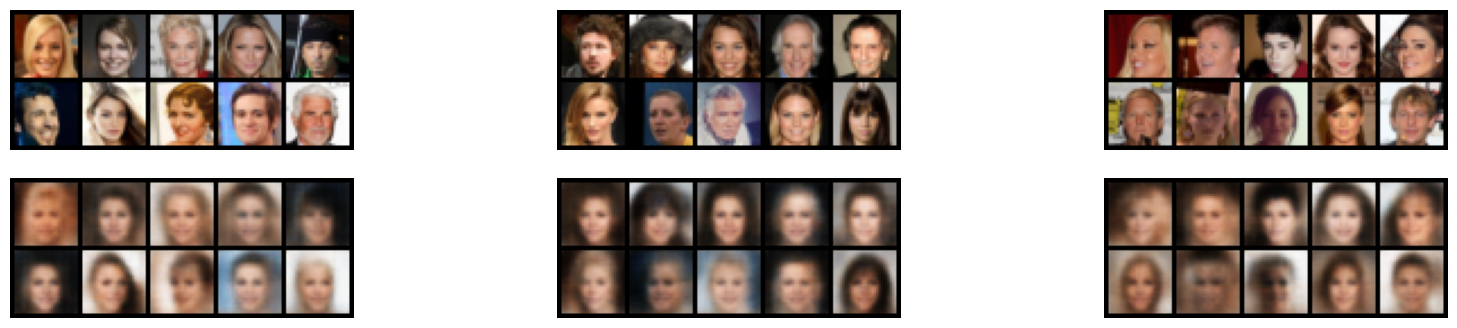

In [46]:
from torchvision import utils
import numpy as np

eval_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Reconstruction visualization
vae.eval()
n = 3  # Number of image batches to display
plt.figure(figsize=(20, 4))
for i in range(n):
    batch, _ = next(iter(eval_loader))
    img_grid = utils.make_grid(batch, nrow=5)

    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    plt.axis("off")

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed, _, _ = vae(batch.to(device))
    img_grid = utils.make_grid(reconstructed.cpu(), nrow=5)
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))
    plt.axis("off")
plt.show()

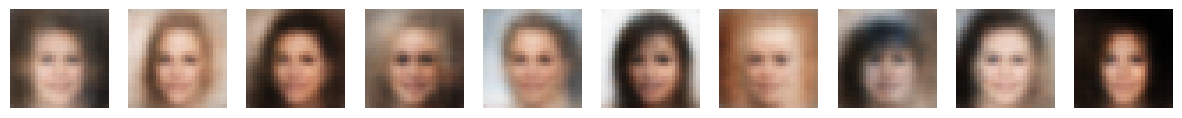

In [48]:
# Random latent gen
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)  # Random latent vectors
    generated = vae.decoder(z).view(-1, 3, 28, 28).cpu()

# Plot generated images
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated[i].permute(1, 2, 0).numpy())
    axes[i].axis('off')
plt.show()

In [55]:
# Get latent space representation
vae.eval()
latents = []
labels = []

train_iter = iter(train_loader)

with torch.no_grad():
    for i in range(16):
        images, label = next(train_iter)
        # images = images.view(images.size(0), -1).to(device)
        images = images.to(device)
        z_mean, z_log_var = vae.encoder(images)
        latents.append(z_mean)#vae.reparameterize(z_mean, z_log_var))
        labels.append(label)

latents = torch.cat(latents).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()
print(latents.shape)
print(labels.shape)

(1024, 512)
(1024, 40)


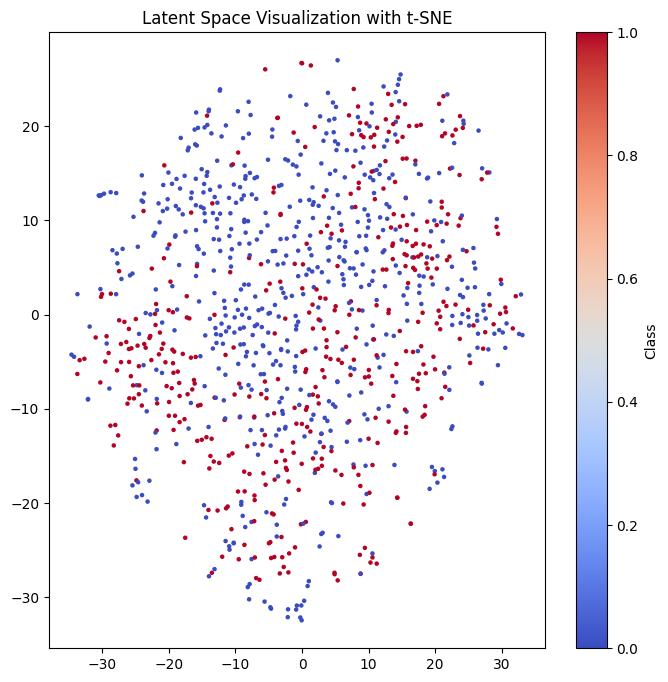

In [56]:
# Perform t-SNE on latent vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d_tsne = tsne.fit_transform(latents)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))

scatter = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=labels[:, 20], cmap='coolwarm', s=5)

plt.colorbar(scatter, label="Class")
plt.title("Latent Space Visualization with t-SNE")
plt.show()

torch.Size([1, 3, 28, 28])
torch.Size([28, 28, 3])
0


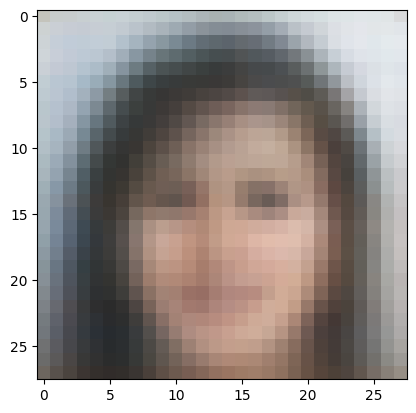

In [60]:
idx = 2
recon = vae.decoder(torch.tensor(latents[idx].reshape(1, 512)).to(device))
print(recon.shape)
print(recon[0].permute(1,2,0).shape)
print(labels[idx][20])
plt.imshow(recon[0].permute(1, 2, 0).cpu().detach().numpy())
plt.show()